In [1]:
import pandas as pd
from pathlib import Path
import math
import matplotlib.pyplot as plt

In [2]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'GPU' or 'CPU' and make it uppercase
    _, implementation, n_docs, n_queries, iteration = parts
    implementation = implementation.upper()
    iteration = int(iteration)
    n_docs = int(n_docs)
    n_queries = int(n_queries)
    
    # Read execution time from file
    execution_time = None
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    if execution_time is None:
        print(f"Failed to parse execution time in {file_path}")
        return None
    return dict(implementation=implementation, n_docs=n_docs, n_queries=n_queries, execution_time=execution_time, iteration=iteration)

In [3]:
# Collect all txt files matching the pattern
files = Path('../results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [item for item in [extract_information(file) for file in files] if item]
df = pd.DataFrame.from_records(data)

print(df)

Failed to parse execution time in ../results/out-cpu-10000-1000-3.txt
Failed to parse execution time in ../results/out-cpu-10000-1000-2.txt
Failed to parse execution time in ../results/out-cpu-10000-1000-1.txt
   implementation  n_docs  n_queries  execution_time  iteration
0             CPU    1000       1000        5497.339          1
1             GPU     100        100         231.586          3
2             CPU   10000         10         564.971          2
3             GPU    1000       1000         255.181          2
4             CPU    1000       1000        5310.489          2
5             GPU   10000       1000       30599.940          2
6             CPU     100         10          10.317          1
7             CPU     100        100          68.481          2
8             CPU     100         10           9.318          2
9             GPU    1000        100         231.395          2
10            GPU   10000       1000       30555.237          3
11            CPU    1

In [4]:
df.sort_values(by=['implementation', 'n_docs', 'n_queries'])

,implementation,n_docs,n_queries,execution_time,iteration
13,CPU,10,10,1.292,2
33,CPU,10,10,1.372,1
34,CPU,10,10,1.214,3
6,CPU,100,10,10.317,1
8,CPU,100,10,9.318,2
35,CPU,100,10,9.304,3
7,CPU,100,100,68.481,2
25,CPU,100,100,56.753,1
46,CPU,100,100,67.488,3
11,CPU,1000,10,64.945,2


In [5]:
agg_df = (
    df[['implementation', 'n_docs', 'n_queries', 'execution_time']]
        .groupby(['implementation', 'n_docs', 'n_queries'])
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df.head()

,implementation,n_docs,n_queries,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,10,1.292667,1.214,1.372,0.079002
1,CPU,100,10,9.646333,9.304,10.317,0.580857
2,CPU,100,100,64.240667,56.753,68.481,6.503490
3,CPU,1000,10,64.983667,64.945,65.046,0.054501
4,CPU,1000,100,558.593000,557.831,559.114,0.674598


In [9]:
cpu_mask = agg_df['implementation']=='CPU'
gpu_mask = agg_df['implementation']=='GPU'

## Execution time vs number of docs

In [16]:
def plot_execution_time_per_n_docs(agg_df, n_queries: int):
    q_mask = agg_df['n_queries']==n_queries

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(agg_df.loc[cpu_mask & q_mask, 'n_docs'], agg_df.loc[cpu_mask & q_mask, 'mean_execution_time'], label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask & q_mask, 'n_docs'], agg_df.loc[gpu_mask & q_mask, 'mean_execution_time'], label='GPU', marker='.', s=100, c='blue')

    ax.set_title(f'Time for different number of documents when number of queries={n_queries}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of documents')
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xticks(agg_df.loc[gpu_mask & q_mask, 'n_docs'], labels=[f"$10^{{{int(math.log(n_docs, 10))}}}$" for n_docs in agg_df.loc[gpu_mask & q_mask, 'n_docs'].values])
    ax.legend()

    return fig

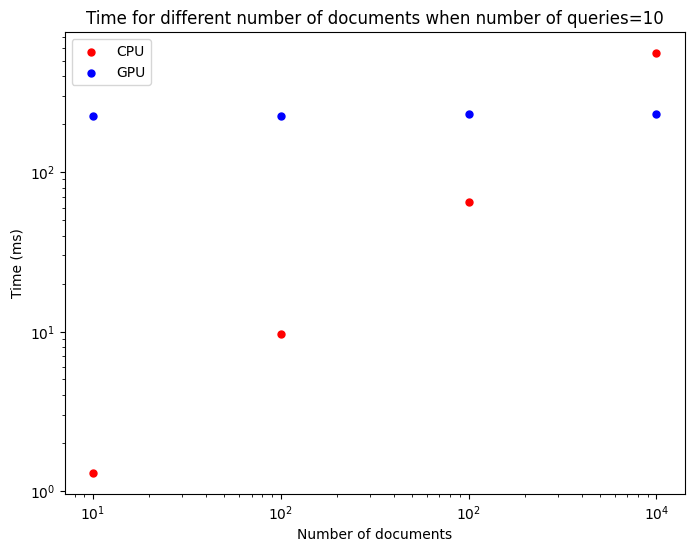

In [18]:
plot_execution_time_per_n_docs(agg_df, 10);

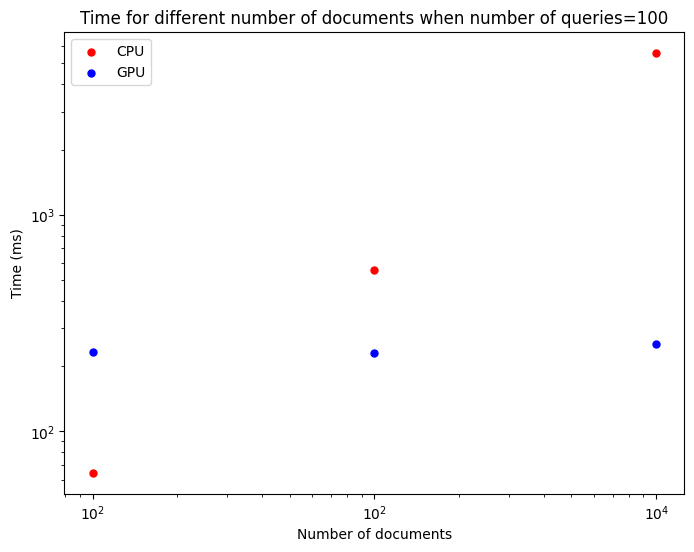

In [19]:
plot_execution_time_per_n_docs(agg_df, 100);

## Execution time vs number of queries

In [21]:
def plot_execution_time_per_n_queries(agg_df, n_docs: int):
    d_mask = agg_df['n_docs']==n_docs

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(agg_df.loc[cpu_mask & d_mask, 'n_queries'], agg_df.loc[cpu_mask & d_mask, 'mean_execution_time'], label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask & d_mask, 'n_queries'], agg_df.loc[gpu_mask & d_mask, 'mean_execution_time'], label='GPU', marker='.', s=100, c='blue')

    ax.set_title(f'Time for different number of queries when number of docs={n_docs}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of queries')
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xticks(agg_df.loc[cpu_mask & d_mask, 'n_queries'], labels=[f"$10^{{{int(math.log(n_docs, 10))}}}$" for n_docs in agg_df.loc[cpu_mask & d_mask, 'n_queries'].values])
    ax.legend()

    return fig

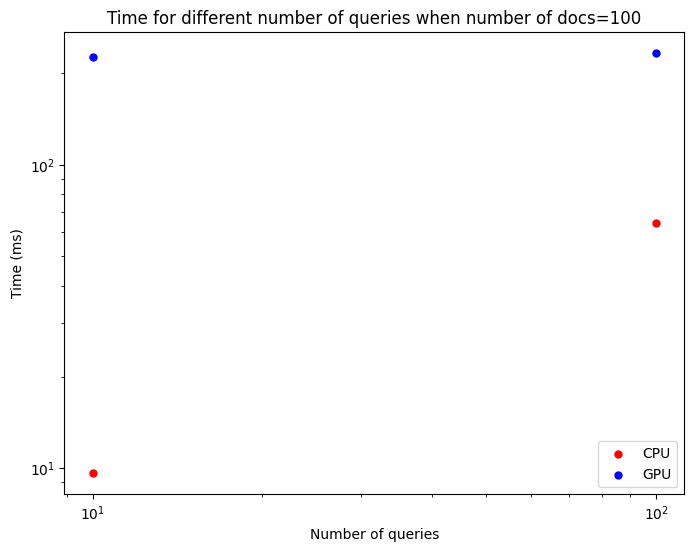

In [25]:
plot_execution_time_per_n_queries(agg_df, 100);

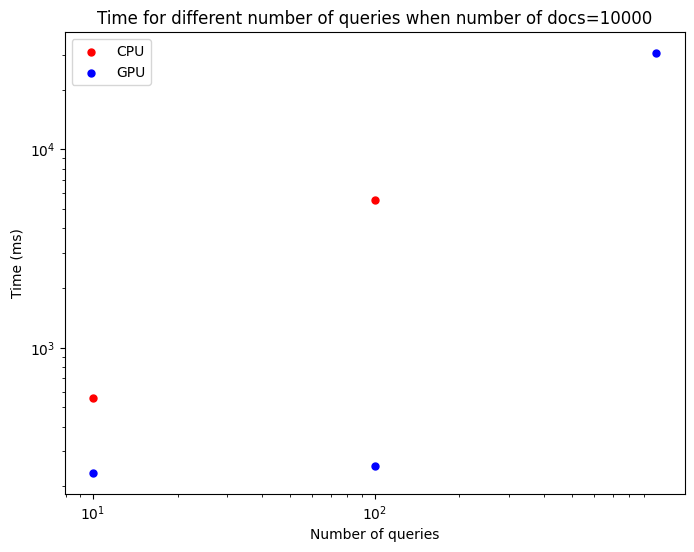

In [24]:
plot_execution_time_per_n_queries(agg_df, 1000);